In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from cplex import Cplex

solver = Cplex()

In [2]:
# effort level for finding multiple optima - 4 indicates maximum effort to find multiple optima
solver.parameters.mip.pool.intensity.set(4)

# absolute tolerance gap for solution pool - solutions in the pool must be at most 0.000001 units apart - did not set to 0.0 due to Python float rounding errors
solver.parameters.mip.pool.absgap.set(0.000001)

# suppress solver outputs
solver.parameters.mip.display.set(0)
solver.set_results_stream(None)

In [3]:
scip_counts = pd.read_csv('scip_counts.csv').drop(columns = 'Most recent MIPLIB version')

scip_counts = scip_counts[scip_counts.iloc[:, 1].str.isdigit()]

scip_counts['Number of distinct optima (SCIP)'] = scip_counts['Number of distinct optima (SCIP)'].astype(int)

scip_counts

,MIPLIB instance,Number of distinct optima (SCIP)
0,set1al,2
1,set1cl,2
2,p0201,4
3,bell3a,5
4,mod008,6
5,p0033,9
6,bell5,16
7,lp4l,24
8,vpm2,33
9,stein9,54


In [4]:
def count_optima(instance_filepath, solver, poplim):

    # set maximum number of solutions in solution pool to poplim argument
    solver.parameters.mip.limits.populate.set(poplim)

    # read in mps file
    solver.read(instance_filepath)

    # get start time before solving for all optima
    start = solver.get_time()

    # solve for all optima
    solver.populate_solution_pool()

    # get end time after solving for all optima
    end = solver.get_time()

    # calculate runtime by subtracting start time from end time
    runtime = end - start

    # count the number of optima in the solution pool
    count = solver.solution.pool.get_num()

    return (count, runtime)

In [5]:
counts = scip_counts['Number of distinct optima (SCIP)']

instances = list(scip_counts['MIPLIB instance']) * 10
poplims = np.concatenate([np.array(counts) * exp for exp in [2**x for x in range(10)]], axis = 0)

In [6]:
runtimes = []
counts = []

for instance, poplim in zip(instances, poplims):

    num_optima, runtime = count_optima(instance_filepath = f'../../mps_files/{instance}.mps',
                                       solver = solver,
                                       poplim = int(poplim))

    counts.append(num_optima)
    runtimes.append(runtime)

In [7]:
results = pd.DataFrame(
    {'MIPLIB instance': instances,
     'POPLIM setting': poplims,
     'CPLEX runtime (seconds)': runtimes,
     'Number of distinct optima (CPLEX)': counts}
)

results = results.merge(scip_counts, 
                        how = 'inner',
                        on = 'MIPLIB instance')

# subtract number of optima enumerated with CPLEX from number of optima enumerated with SCIP
results['Number of missed optima'] = results.apply(lambda x: int(x['Number of distinct optima (SCIP)']) - x['Number of distinct optima (CPLEX)'],
                                                   axis = 1)

results.sort_values(by = ['MIPLIB instance', 'POPLIM setting'],
                    inplace = True)

results.insert(2, 'POPLIM ratio', [2 ** x for x in range(10)] * len(set(instances)))

results.head(20)

,MIPLIB instance,POPLIM setting,POPLIM ratio,CPLEX runtime (seconds),Number of distinct optima (CPLEX),Number of distinct optima (SCIP),Number of missed optima
3,bell3a,5,1,1.739718,5,5,0
18,bell3a,10,2,1.319009,5,5,0
33,bell3a,20,4,1.631687,5,5,0
48,bell3a,40,8,1.325309,5,5,0
63,bell3a,80,16,2.180391,5,5,0
78,bell3a,160,32,1.509813,5,5,0
93,bell3a,320,64,1.386667,5,5,0
108,bell3a,640,128,2.542038,5,5,0
123,bell3a,1280,256,1.545143,5,5,0
138,bell3a,2560,512,1.248721,5,5,0


#### For 3 instances, CPLEX fails to find all optima when POPLIM setting is set to the exact number of optima

In [8]:
results[results['Number of missed optima'] != 0]

,MIPLIB instance,POPLIM setting,POPLIM ratio,CPLEX runtime (seconds),Number of distinct optima (CPLEX),Number of distinct optima (SCIP),Number of missed optima
0,set1al,2,1,0.064670,1,2,1
1,set1cl,2,1,0.040650,1,2,1
8,vpm2,33,1,0.572067,31,33,2


#### Correlation between Runtime and POPLIM ratio (POPLIM setting divided by number of optima)

In [9]:
results.groupby('MIPLIB instance')[['CPLEX runtime (seconds)',
                                    'POPLIM ratio']].apply(lambda x: x.iloc[:, 0].corr(x.iloc[:, 1])).sort_values().reset_index().rename(columns = {0: 'Pearson Correlation between POPLIM Ratio and Runtime'})

,MIPLIB instance,Pearson Correlation between POPLIM Ratio and Runtime
0,stein15,-0.524880
1,stein27,-0.511652
2,supportcase14,-0.455868
3,supportcase16,-0.425002
4,vpm2,-0.389531
5,stein45,-0.389433
6,set1al,-0.379192
7,p0201,-0.345146
8,stein9,-0.300911
9,bell3a,-0.205257


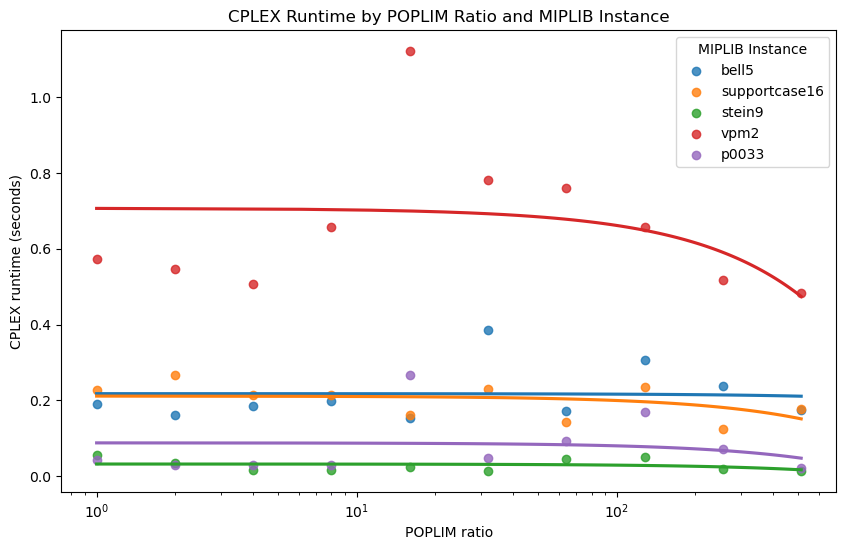

In [12]:
plt.figure(figsize = (10, 6))

for instance, color in zip(np.random.choice(results['MIPLIB instance'].unique(), 5, replace = False), ['red', 'orange', 'green', 'blue', 'purple']):
    ax = sns.regplot(x = 'POPLIM ratio',
                     y = 'CPLEX runtime (seconds)',
                     ci = False,
                     label = instance,
                     data = results[results['MIPLIB instance'] == instance])

ax.legend(title = 'MIPLIB Instance')

plt.title('CPLEX Runtime by POPLIM Ratio and MIPLIB Instance')

plt.xscale('log')

plt.show()

In [11]:
# write results to csv file
results.to_csv('results_poplim.csv', index = False)